In [4]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

## PolyA gene transcript detection

What fraction of polyA genes from the annotation do we detect with at least 1 known isoform >= 1 TPM in any library?

In [7]:
df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
df, tids = get_tpm_table(df,
                   how='iso',
                   nov=['Known'],
                   min_tpm=1,
                   gene_subset='polya')

Calculating iso TPM values
Subsetting for novelty categories ['Known']
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 3556147
# isos >= 1 tpm: 1384634
Applying gene type and novelty subset
Number of isos reported: 65469


In [8]:
# merge with gene id
gene_df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
gene_df = gene_df[['annot_gene_id', 'annot_transcript_id']]
df = df.merge(gene_df, how='left', left_index=True, right_on='annot_transcript_id')

In [9]:
gene_df, _, _ = get_gtf_info(how='gene')

polya_biotypes = ['protein_coding', 'pseudogene', 'lncRNA']
polya_genes = gene_df.loc[gene_df.biotype_category.isin(polya_biotypes), 'gid'].tolist()
n_polya = len(polya_genes)
n_det_polya = len(df.annot_gene_id.unique().tolist())

print('Detected {} / {} annotated polyA genes w/ at least 1 known transcript >= 1 TPM'.format(n_det_polya, n_polya))

Detected 23073 / 49472 annotated polyA genes w/ at least 1 known transcript >= 1 TPM


## TF gene transcript detection

What fraction of TF genes from the annotation do we detect with at least 1 known isoform >= 1 TPM in any library?

In [10]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
df, tids = get_tpm_table(df,
                   how='iso',
                   nov=['Known'],
                   min_tpm=1,
                   gene_subset='tf')

# merge with gene id
gene_df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
gene_df = gene_df[['annot_gene_id', 'annot_transcript_id']]
df = df.merge(gene_df, how='left', left_index=True, right_on='annot_transcript_id')

gene_df, _, _ = get_gtf_info(how='gene', subset='tf')

n_tf = len(gene_df.index)
n_det_tf = len(df.annot_gene_id.unique().tolist())

print('Detected {} / {} annotated TF genes w/ at least 1 known transcript >= 1 TPM'.format(n_det_tf, n_tf))

Calculating iso TPM values
Subsetting for novelty categories ['Known']
Subsetting for tf genes
Enforcing minimum TPM
Total # isos detected: 156027
# isos >= 1 tpm: 141390
Applying gene type and novelty subset
Number of isos reported: 4304
Detected 1271 / 1419 annotated TF genes w/ at least 1 known transcript >= 1 TPM


## Protein coding gene transcript detection

What fraction of protein-coding genes do we detect with at least 1 known isoform >= 1 TPM in any library?

In [11]:
df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
# no gene subset here so we can look at all other genes
df, tids = get_tpm_table(df,
                   how='iso',
                   nov=['Known'],
                   min_tpm=1)

Calculating iso TPM values
Subsetting for novelty categories ['Known']
Enforcing minimum TPM
Total # isos detected: 3556147
# isos >= 1 tpm: 1384634
Applying gene type and novelty subset
Number of isos reported: 67059


In [12]:
# merge with gene id
gene_df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
gene_df = gene_df[['annot_gene_id', 'annot_transcript_id']]
df = df.merge(gene_df, how='left', left_index=True, right_on='annot_transcript_id')

In [13]:
gene_df, b_counts, b_cat_counts = get_gtf_info(how='gene')
df = df.merge(gene_df, how='left', left_on='annot_gene_id', right_on='gid')

In [14]:
#### temp = df[['gid', 'biotype_category']].drop_duplicates().groupby('biotype_category').count()
temp.reset_index(inplace=True)
temp.rename({'gid': 'detected_counts'}, axis=1, inplace=True)

temp = temp.merge(b_cat_counts, on='biotype_category', how='outer')
temp['prop_detected'] = temp.detected_counts/temp.gencode_counts
temp.sort_values(by='prop_detected', ascending=False, inplace=True)
temp

,biotype_category,detected_counts,gencode_counts,prop_detected
3,protein_coding,16656,19969,0.834093
0,lncRNA,4087,15006,0.272358
2,other,1339,7426,0.180312
4,pseudogene,2330,14497,0.160723
1,miRNA,246,1881,0.130781


## What fraction of protein coding gene transcripts do we detect?

Of the transcripts associated with protein coding genes GENCODE, how many do we detect >=1 TPM?

In [15]:
df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
df, tids = get_tpm_table(df,
                   how='iso',
                   nov=['Known'],
                   min_tpm=1,
                   gene_subset='polya')

Calculating iso TPM values
Subsetting for novelty categories ['Known']
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 3556147
# isos >= 1 tpm: 1384634
Applying gene type and novelty subset
Number of isos reported: 65469


In [16]:
t_df, b_counts, b_cat_counts = get_gtf_info(how='iso')
df = df.merge(t_df, how='left', left_index=True, right_on='tid')

In [17]:
temp = df[['tid', 'biotype_category']].groupby('biotype_category').count()
temp.reset_index(inplace=True)
temp.rename({'tid': 'detected_counts'}, axis=1, inplace=True)

temp = temp.merge(b_cat_counts, on='biotype_category', how='outer')
temp['prop_detected'] = temp.detected_counts/temp.gencode_counts
temp.sort_values(by='prop_detected', ascending=False, inplace=True)
temp

,biotype_category,detected_counts,gencode_counts,prop_detected
1,protein_coding,56835.0,151259,0.375746
0,lncRNA,5891.0,28478,0.206861
2,pseudogene,2743.0,17657,0.155349
3,miRNA,NaN,1881,NaN
4,other,NaN,7486,NaN


## Characteristics of detected known, polyA gene associated transcripts

## Number of cell types or tissues that each known transcript from polyA genes is expressed >= 1 TPM

Calculating iso TPM values
Subsetting for novelty categories ['Known']
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 3556147
# isos >= 1 tpm: 1384634
Applying gene type and novelty subset
Number of isos reported: 65469
Found 31 total samples


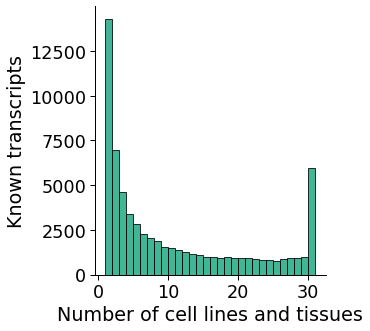

In [18]:
df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
df = plot_biosamp_det(df,
                      how='iso',
                      min_tpm=1,
                      gene_subset='polya',
                      sample=None,
                      groupby='sample',
                      nov='Known',
                      opref='figures/human')

In [19]:
specific_thresh = 4
ubiq_thresh = 20

n_iso = len(df.index)
n_specific = len(df.loc[df.n_samples <= specific_thresh].index)
n_ubiq = len(df.loc[df.n_samples >= ubiq_thresh].index)

print('{} / {} ({:.1f}%) transcripts are expressed in <= {} samples'.format(n_specific, n_iso, (n_specific/n_iso)*100, specific_thresh))
print('{} / {} ({:.1f}%) transcripts are expressed in >= {} samples'.format(n_ubiq, n_iso, (n_ubiq/n_iso)*100, ubiq_thresh))

29214 / 65469 (44.6%) transcripts are expressed in <= 4 samples
14674 / 65469 (22.4%) transcripts are expressed in >= 20 samples


## Length of transcripts from polyA genes detected >= 1 TPM

Calculating iso TPM values
Subsetting for novelty categories ['Known']
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 156027
# isos >= 1 tpm: 141390
Applying gene type and novelty subset
Number of isos reported: 68897


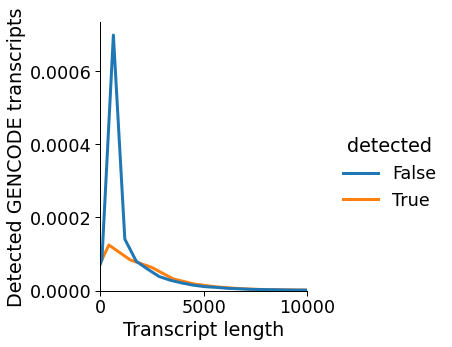

In [20]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
df = plot_det_len_kde(df, 
                      how='iso', 
                      subset='polya',
                      min_tpm=1,
                      xlim=10000,
                      opref='figures/')

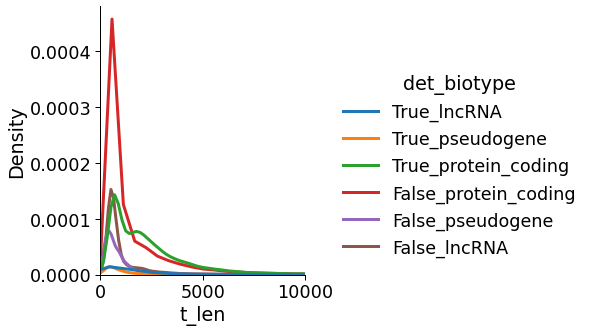

In [21]:
df['det_biotype'] = df.detected.astype('str')+'_'+df.biotype_category
ax = sns.displot(data=df, x='t_len', kind='kde',
                     linewidth=3, hue='det_biotype', common_norm=True)
ax.set(xlim=(0,10000))

What is the longest detected transcript with more than one exon?

In [22]:
t_df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
t_df = t_df[['annot_transcript_id', 'n_exons']]

In [23]:
df = df.merge(t_df, how='left', on='annot_transcript_id')

In [24]:
n = df.loc[(df.detected == True)&(df.n_exons > 1), 't_len'].max()
print(n)

37852


In [25]:
df.loc[df.t_len == 37852]

,annot_transcript_id,tid,t_len,gid,biotype,biotype_category,tf,detected,det_biotype,n_exons
65322,ENST00000458178.2,ENST00000458178.2,37852,ENSG00000224086.5,antisense,lncRNA,False,True,True_lncRNA,2.0


## Variance in TPM levels >= 1 TPM for known transcripts detected >= 1 TPM

In [26]:
df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
df = get_tpm_table(df,
                   how='iso',
                   nov=['Known'],
                   min_tpm=1,
                   gene_subset='polya')

Calculating iso TPM values
Subsetting for novelty categories ['Known']
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 3556147
# isos >= 1 tpm: 1384634
Applying gene type and novelty subset
Number of isos reported: 65469


## How many known polyA transcripts do we detect?

In [29]:
df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
df, _ = get_tpm_table(df,
                   how='iso',
                   nov=['Known'],
                   min_tpm=1,
                   gene_subset='polya')

Calculating iso TPM values
Subsetting for novelty categories ['Known']
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 3556147
# isos >= 1 tpm: 1384634
Applying gene type and novelty subset
Number of isos reported: 65469


In [30]:
# merge with transcript len
t_df, b_counts, c_counts = get_gtf_info(how='iso')
df = df.merge(t_df, how='left', left_index=True, right_on='tid')

In [31]:
polya_biotypes = ['protein_coding', 'pseudogene', 'lncRNA']
n_det_polya = len(df.index)
n_known_polya = c_counts.loc[c_counts.biotype_category.isin(polya_biotypes), 'gencode_counts'].sum()
print('Detected {} / {} annotated transcripts from polyA genes >= 1 TPM'.format(n_det_polya, n_known_polya))

Detected 65469 / 197394 annotated transcripts from polyA genes >= 1 TPM


## How many complete isoforms do we detect?

In [32]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
df, tids = get_tpm_table(df,
                   how='iso',
                   nov=['Known', 'NIC', 'NNC'],
                   min_tpm=1,
                   gene_subset='polya')

Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC']
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 156027
# isos >= 1 tpm: 141390
Applying gene type and novelty subset
Number of isos reported: 92963


  transcript_novelty  counts
0              Known   68897
1                NIC   18270
2                NNC    5796
Number of complete isoforms: 92963


<Figure size 288x432 with 0 Axes>

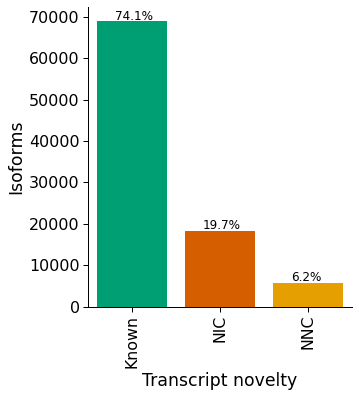

<Figure size 432x288 with 0 Axes>

In [33]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
plot_transcript_novelty(df,
                        oprefix='figures/complete_det',
                        whitelist=tids,
                        novs=['Known', 'NIC', 'NNC'])

## How many exons are in each complete, detected model, split by novelty?

Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC']
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 156027
# isos >= 1 tpm: 141390
Applying gene type and novelty subset
Number of isos reported: 92963


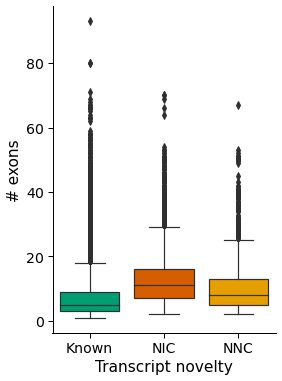

In [34]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
plot_exons_per_iso(df,
                   nov=['Known', 'NIC', 'NNC'],
                   min_tpm=1,
                   gene_subset='polya',
                   opref='figures/human')

## How many isoforms per gene do we detect per sample? 

What is the average and range of complete isoforms per polyA gene that we detect per sample?

In [3]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
df = get_isos_per_gene(df,
                       min_tpm=1,
                       gene_subset='polya',
                       groupby='sample', 
                       nov=['Known', 'NIC', 'NNC'])

Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC']
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 156027
# isos >= 1 tpm: 141390
Applying gene type and novelty subset
Number of isos reported: 92963
Found 31 total samples


In [4]:
df.idxmax(axis=1)

annot_gene_id
ENSG00000000003.14              colon
ENSG00000000005.5        h9_panc_beta
ENSG00000000419.12    h9_neural_crest
ENSG00000000457.13    h9_neural_crest
ENSG00000000460.16     h9_panc_progen
                           ...       
ENSG00000285944.1               heart
ENSG00000285966.1               hffc6
ENSG00000285967.1          h9_chondro
ENSG00000285972.1               colon
ENSG00000285976.1             adipose
Length: 23990, dtype: object

In [5]:
print('Average # isoforms / gene / sample: {}'.format(df.mean().mean()))

Average # isoforms / gene / sample: 1.3769514179295137


In [6]:
print('Max # isoforms / gene / sample: {}'.format(df.max().max()))

Max # isoforms / gene / sample: 134


Deeper dive into what's going on with _ELN_

In [7]:
temp = df.max(axis=1).to_frame()
temp.loc[temp[0] == 134]

,0
annot_gene_id,
ENSG00000049540.16,134


In [8]:
df.loc['ENSG00000049540.16'].idxmax()

'h9_chondro'

In [9]:
df.loc['ENSG00000049540.16', 'h9_chondro']

134

How many different tissues express Elastin? How many isoforms are detected in these tissues?

In [11]:
df.loc['ENSG00000049540.16']

adipose                 7
adrenal gland           1
colon                  12
gm12878                 0
h9                      0
h9_chondro            134
h9_de                   0
h9_neural_crest         0
h9_osteocyte            0
h9_panc_beta            0
h9_panc_progen          0
hct116                  0
heart                  41
hepg2                   0
hffc6                   2
hl60                    0
imr90                   3
k562                    0
kidney                  6
liver                   4
lung                   18
mcf7                    0
muscle                  5
ovary                   7
panc1                   0
pc3                     0
pgp1                    0
pgp1_astro              2
pgp1_endo               4
pgp1_excite_neuron      0
vessels                41
Name: ENSG00000049540.16, dtype: int64

Which samples have the highest average?

Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC']
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 156027
# isos >= 1 tpm: 141390
Applying gene type and novelty subset
Number of isos reported: 92963
Found 31 total samples


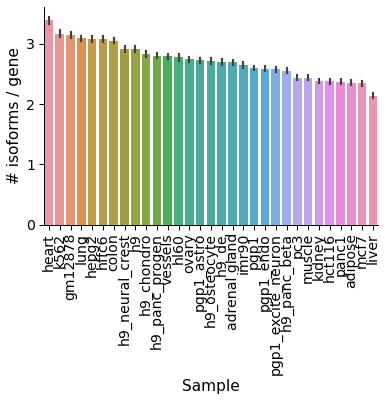

In [47]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
plot_avg_isos_per_gene(df,
                       min_tpm=1,
                       gene_subset='polya',
                       sample='all', 
                       groupby='sample',
                       nov=['Known', 'NIC', 'NNC'],
                       opref='figures/human')

Calculating iso TPM values
Subsetting for tissue datasets
Subsetting for novelty categories ['Known', 'NIC', 'NNC']
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 156027
# isos >= 1 tpm: 124187
Applying gene type and novelty subset
Number of isos reported: 78703
Found 10 total samples


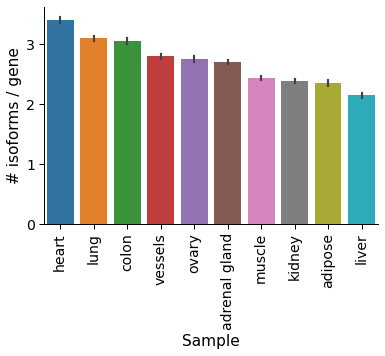

In [48]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
plot_avg_isos_per_gene(df,
                       min_tpm=1,
                       gene_subset='polya',
                       sample='tissue', 
                       groupby='sample',
                       nov=['Known', 'NIC', 'NNC'],
                       opref='figures/human')

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

What's the distribution of number of isoforms detected per gene per sample?

In [8]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
df = plot_isos_per_gene_hist(df,
                       min_tpm=1,
                       gene_subset='polya',
                       groupby='sample', 
                       nov=['Known', 'NIC', 'NNC'])

Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC']
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 156027
# isos >= 1 tpm: 141390
Applying gene type and novelty subset
Number of isos reported: 92963
Found 31 total samples


In [9]:
df.head()

,adipose,adrenal gland,colon,gm12878,h9,h9_chondro,h9_de,h9_neural_crest,h9_osteocyte,h9_panc_beta,...,mcf7,muscle,ovary,panc1,pc3,pgp1,pgp1_astro,pgp1_endo,pgp1_excite_neuron,vessels
annot_gene_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003.14,4,3,6,1,6,2,5,6,5,6,...,3,2,4,2,3,5,3,4,3,3
ENSG00000000005.5,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
ENSG00000000419.12,2,4,5,6,5,6,4,7,5,5,...,5,4,4,4,5,5,6,3,5,5
ENSG00000000457.13,1,2,1,1,2,1,2,4,3,1,...,1,2,1,2,1,1,2,1,0,1
ENSG00000000460.16,0,2,2,5,3,1,2,5,2,3,...,2,0,1,1,1,4,1,1,2,1


In [10]:
df = df.melt(ignore_index=False)

In [11]:
df.head()

,variable,value
annot_gene_id,,
ENSG00000000003.14,adipose,4
ENSG00000000005.5,adipose,0
ENSG00000000419.12,adipose,2
ENSG00000000457.13,adipose,1
ENSG00000000460.16,adipose,0


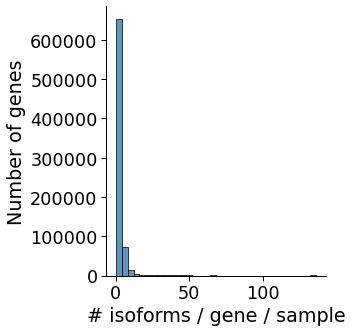

In [22]:
opref = 'figures/human'
sns.set_context('paper', font_scale=2)

ax = sns.displot(data=df, x='value', kind='hist', binwidth=4)
xlabel = '# isoforms / gene / sample'
ylabel = 'Number of genes'

_ = ax.set(xlabel=xlabel, ylabel=ylabel)

plt.savefig('{}_hist_isos_per_gene_per_sample.png'.format(opref), \
            dpi=300, bbox_inches='tight')

Number of libraries per sample

Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC']
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 156027
# isos >= 1 tpm: 141390
Applying gene type and novelty subset
Number of isos reported: 92963
Found 31 total samples
Slope of correlation: 0.08353043005138618
R of correlation: 0.7613102220824205
R2 of correlation: 0.7859059598018525


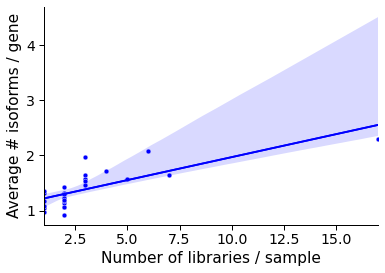

In [2]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
plot_n_libs_v_avg_isos(df,
                        min_tpm=1,
                        gene_subset='polya',
                        sample='all',
                        nov=['Known', 'NIC', 'NNC'], 
                        opref='figures/human')

Number of reads per sample

Found 31 total samples
Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC']
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 156027
# isos >= 1 tpm: 141390
Applying gene type and novelty subset
Number of isos reported: 92963
Found 31 total samples
Slope of correlation: 5.6591098513634346e-08
R of correlation: 0.6818764774053215
R2 of correlation: 0.4794354838709678


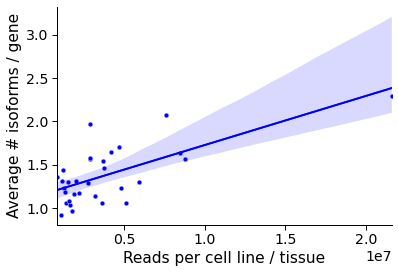

In [3]:
df = pd.read_csv('human_talon_abundance.tsv', sep='\t')
filt_df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
plot_n_reads_v_avg_isos(df, filt_df,
                        min_tpm=1,
                        gene_subset='polya',
                        sample='all',
                        groupby='sample',
                        nov=['Known', 'NIC', 'NNC'], 
                        opref='figures/human')

What fraction of polyA genes express >= 2 complete isoforms in more than half of their expressed samples?

In [51]:
filt_df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
df = pd.read_csv('human_talon_abundance.tsv', sep='\t')

df = get_gene_iso_det_table(df, filt_df,
                            min_isos=2,
                            iso_nov=['Known', 'NIC', 'NNC'],
                            gene_nov=['Known'],
                            gene_subset='polya',
                            min_tpm=1,
                            sample='all',
                            groupby='sample')

Calculating gene TPM values
Subsetting for novelty categories ['Known']
Subsetting for polya genes
Enforcing minimum TPM
Total # genes detected: 352297
# genes >= 1 tpm: 217535
Applying gene type and novelty subset
Number of genes reported: 31968
Found 31 total samples
Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC']
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 156027
# isos >= 1 tpm: 141390
Applying gene type and novelty subset
Number of isos reported: 92963
Found 31 total samples


In [52]:
df = df.apply(pd.Series.value_counts)
df = df.transpose()
df.fillna(0, inplace=True)
df.rename({'00': 'no_det',
             '01': 'gene_det',
             '10': 'iso_det',
             '11': 'gene_iso_det'}, axis=1, inplace=True)

df['total_gene_det'] = df['gene_det']+df['gene_iso_det']
df['prop'] = df['gene_iso_det']/df['total_gene_det']

n_gene_iso = len(df.loc[df.prop >= .5])
n = len(df.index)

print('{} / {} detected polyA genes express >=2 isoforms in at least half of their expressed samples'.format(n_gene_iso, n))

8274 / 31968 detected polyA genes express >=2 isoforms in at least half of their expressed samples


What fraction of TF genes express >= 2 complete isoforms in more than half of their expressed samples?


In [59]:
filt_df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
df = pd.read_csv('human_talon_abundance.tsv', sep='\t')

df = get_gene_iso_det_table(df, filt_df,
                            min_isos=2,
                            iso_nov=['Known', 'NIC', 'NNC'],
                            gene_nov=['Known'],
                            gene_subset='tf',
                            min_tpm=1,
                            sample='all',
                            groupby='sample')

Calculating gene TPM values
Subsetting for novelty categories ['Known']
Subsetting for tf genes
Enforcing minimum TPM
Total # genes detected: 352297
# genes >= 1 tpm: 217535
Applying gene type and novelty subset
Number of genes reported: 1355
Found 31 total samples
Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC']
Subsetting for tf genes
Enforcing minimum TPM
Total # isos detected: 156027
# isos >= 1 tpm: 141390
Applying gene type and novelty subset
Number of isos reported: 5201
Found 31 total samples


In [60]:
df = df.apply(pd.Series.value_counts)
df = df.transpose()
df.fillna(0, inplace=True)
df.rename({'00': 'no_det',
             '01': 'gene_det',
             '10': 'iso_det',
             '11': 'gene_iso_det'}, axis=1, inplace=True)

df['total_gene_det'] = df['gene_det']+df['gene_iso_det']
df['prop'] = df['gene_iso_det']/df['total_gene_det']

n_gene_iso = len(df.loc[df.prop >= .5])
n = len(df.index)

print('{} / {} detected TF genes express >=2 isoforms in at least half of their expressed samples'.format(n_gene_iso, n))

518 / 1355 detected TF genes express >=2 isoforms in at least half of their expressed samples


What fraction of polyA genes have >= 2 complete isoforms detected in the same sample?

In [61]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
df = get_isos_per_gene(df,
                       min_tpm=1,
                       gene_subset='polya',
                       groupby='sample', 
                       nov=['Known', 'NIC', 'NNC'])

Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC']
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 156027
# isos >= 1 tpm: 141390
Applying gene type and novelty subset
Number of isos reported: 92963
Found 31 total samples


In [62]:
gene_df, b_counts, b_cat_counts = get_gtf_info(how='gene', subset='polya')
n_polya = len(gene_df.index)

df = df.loc[(df > 2).any(axis=1)]
n_det_polya = len(df.index)

print('{} / {} annotated polyA genes have >= 2 isoforms expressed in >= 1 sample'.format(n_det_polya, n_polya))

10672 / 49472 annotated polyA genes have >= 2 isoforms expressed in >= 1 sample


What fraction of TF genes have >= 2 complete isoforms detected in the same sample?

In [63]:
df = pd.read_csv('human_talon_abundance_filtered.tsv', sep='\t')
df = get_isos_per_gene(df,
                       min_tpm=1,
                       gene_subset='tf',
                       groupby='sample', 
                       nov=['Known', 'NIC', 'NNC'])

Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC']
Subsetting for tf genes
Enforcing minimum TPM
Total # isos detected: 156027
# isos >= 1 tpm: 141390
Applying gene type and novelty subset
Number of isos reported: 5201
Found 31 total samples


In [64]:
gene_df, b_counts, b_cat_counts = get_gtf_info(how='gene', subset='tf')
n_polya = len(gene_df.index)

df = df.loc[(df > 2).any(axis=1)]
n_det_polya = len(df.index)

print('{} / {} annotated TF genes have >= 2 isoforms expressed in >= 1 sample'.format(n_det_polya, n_polya))

698 / 1419 annotated TF genes have >= 2 isoforms expressed in >= 1 sample
